# GENERATIVE ADVERSARIAL NETWORK (GAN)

**This is implementation of GAN with R1 Regularizer to generate India Car images. GAN network is build on 700+ Indian car dataset collected through google images.**

In [ ]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)
cuda avaiable: True, Device: cuda:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session6-GAN/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session6-GAN/notebooks


In [ ]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [ ]:
import shutil
#shutil.rmtree('./logs/logs_rgan_tmp')

In [ ]:
from pathlib import Path

# important folders used in this application

Path(f'logs').mkdir(exist_ok=True)

SOLUTION_LOG_DIR = f"logs/logs_rgan_new1"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [ ]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=64,
    num_workers=6,
    epochs=3000,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False, 
    load_model_path = Path(f'./logs/saved_models/ep1_testloss_1.322092000.pth'), # used when resume_training is True
    #load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [ ]:
# dataset path where zip files are placed. this contains LFW and own images combined
dataset_zip_file = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session6-gan/car_dataset.zip'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s6_dataset'

## Preparing Dataset

In [ ]:
import utils.data_utils as dutils
import shutil

if Path(root_dataset).exists():
  shutil.rmtree(root_dataset)

In [ ]:
# Extracting zipped dataset into colab internal memory
%%time

# Extracting dataset
if not Path(root_dataset).exists():
    print(f'Extracting car dataset images...')
    dutils.extract_dataset(fn=dataset_zip_file, dest=root_dataset)

# dataset size
dutils.get_dataset_count(root_dataset)
print('\n')

Extracting car dataset images...

Total images in dataset: 704


CPU times: user 349 ms, sys: 117 ms, total: 466 ms
Wall time: 4.19 s


In [ ]:
from PIL import Image
from tqdm import tqdm

'''
it scan all files and check if all the images can be read as image file..
return all the error files as list
'''
def scan_files_validity(rootdir, classname):
    invalid_files = []
    classdir = os.path.join(rootdir, classname)
    pbar = tqdm(Path(f'{classdir}/').glob('*.*'))
    for p in pbar:
      try:
        #print(f'image : {p}')
        im = Image.open(p)
        im2 = im.convert('RGB')
        #print(np.array(im2).shape)
      except OSError:
        print(f'Cannot load : {p}')
        invalid_files.append(p)

      pbar.set_description(desc=f'Scanning {classname} images..')
    return invalid_files

def scan_dataset(rootdir, classlist):
    errfiles = []
    for classname in classlist:
      invalid_files = scan_files_validity(rootdir, classname)
      errfiles.extend(invalid_files)
    return errfiles

In [ ]:

scan_dataset(root_dataset, ['car'])

Scanning car images..: : 704it [00:05, 125.55it/s]


[]

# Prepare Data Transforms and DataLoader

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms

import glob
from PIL import Image
import os, sys
import datetime

In [ ]:
from torchvision import transforms
IMAGE_DIM = (64, 64, 3)
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transforms.Compose([
                                transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                #transforms.ColorJitter(brightness=0.30, contrast=0.30),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean,std=std)
                               ])

In [ ]:
dataset = datasets.ImageFolder(root=f'{root_dataset}', transform=transform)
dataloader_args = dict(shuffle=True, batch_size=config_params["batch_size"], drop_last=True, num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)
data_loader = DataLoader(dataset=dataset, **dataloader_args)

In [ ]:
print(f'Train size: {len(data_loader.dataset)}')

Train size: 704


# Visualize few training images

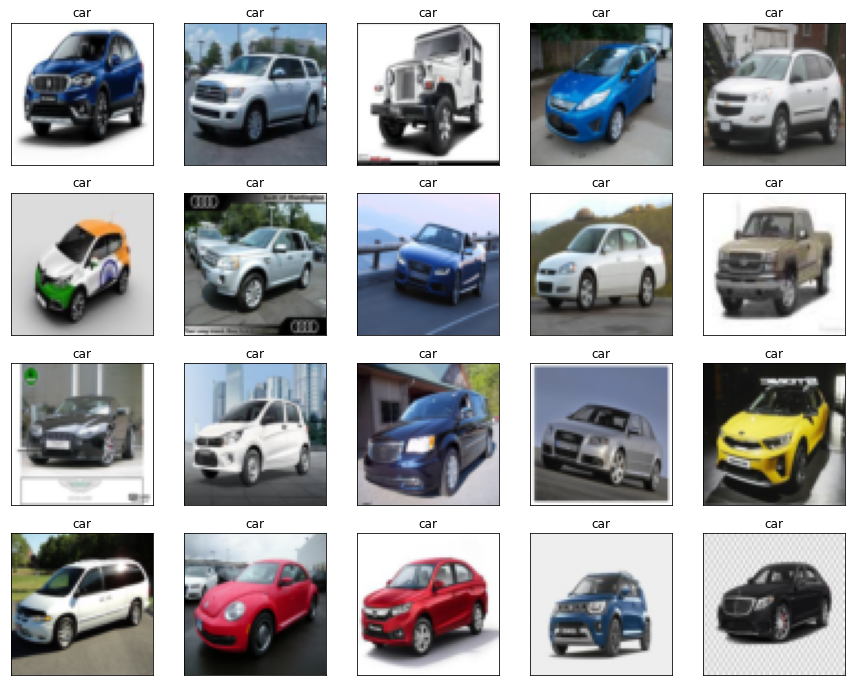

In [ ]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, ['car'], mean, std)

# visualize how image augmentation is applied on few training dataset images: 
putils.plot_dataset_images(data_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

# Discriminator and Generator Network Model

In [ ]:
from models.gan_net import ResidualBlock, Discriminator, Generator

In [ ]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

def get_sample_image(device, G, n_noise=100, n_samples=64):
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(device) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return np.clip(result,0,1)

In [ ]:
max_epoch = config_params["epochs"]
step = 0
n_noise = 256
batch_size = config_params["batch_size"]

r1_gamma = 10
steps_per_epoch = len(data_loader.dataset) // batch_size

log_term = 10 # epochs
save_term = 100 # epochs

print(f'steps_per_epoch: {steps_per_epoch}')

steps_per_epoch: 11


In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(device)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(device)

In [ ]:
# criterion = nn.L1Loss()
def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l*inputs).mean()

D_opt = torch.optim.RMSprop(D.parameters(), lr=1e-4, alpha=0.99)
G_opt = torch.optim.RMSprop(G.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
# D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
# G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
MODEL_NAME = 'R1GAN'

# store all losses
d_fake_losses = []
d_real_losses = []
d_losses = []
g_losses = []

def save_losses(d_realloss, d_fakeloss,d_loss, g_loss):
    d_real_losses.append(d_realloss)
    d_fake_losses.append(d_fakeloss)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

for epoch in range(max_epoch):
    #for idx, images in enumerate(tqdm(data_loader, total=len(data_loader))):
    for idx, (images, labels) in enumerate(data_loader):
        G.zero_grad()
        # Training Discriminator
        x = images.to(device)
        x.requires_grad = True
        x_outputs = D(x)
        d_real_loss = r1loss(x_outputs, True)
        # Reference >> https://github.com/rosinality/style-based-gan-pytorch/blob/a3d000e707b70d1a5fc277912dc9d7432d6e6069/train.py
        # little different with original DiracGAN
        grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5*r1_gamma*grad_penalty
        D_x_loss = d_real_loss + grad_penalty

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(device)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = r1loss(z_outputs, False)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(device)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = r1loss(z_outputs, True)
        
        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if idx == (len(data_loader)-1):
          save_losses(D_x_loss, D_z_loss, D_loss.item(), G_loss.item())

        if (epoch % save_term == 0) and (idx == (len(data_loader)-1)):
          torch.save(D, f'{SAVED_MODELS_DIR}/epoch{epoch}_r1gan_D_cuda.pt')
          torch.save(G, f'{SAVED_MODELS_DIR}/epoch{epoch}_r1gan_G_cuda.pt')
        
        '''
        if (epoch % save_term == 0) and (idx == (len(data_loader)-1)):
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                f'{SAVED_MODELS_DIR}/r1gan_epoch{epoch}.pth.tar')
        '''
        
        if (epoch % log_term == 0) and (idx == (len(data_loader)-1)):
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, gp: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), grad_penalty.item(), dt))
            G.eval()
            img = get_sample_image(device, G, n_noise, n_samples=25)
            plt.imsave(f'{SAVED_RESULTS_DIR}/{MODEL_NAME}_epoch{epoch}.jpg', img)
            G.train()
        
        step += 1
#     D_scheduler.step()
#     G_scheduler.step()

Epoch: 0/3000, Step: 10, D Loss: 1.1254, G Loss: 1.1091, gp: 0.0047, Time:16:17:48
Epoch: 20/3000, Step: 230, D Loss: 0.5584, G Loss: 1.7266, gp: 0.1910, Time:16:20:16
Epoch: 40/3000, Step: 450, D Loss: 1.1592, G Loss: 1.9925, gp: 0.0754, Time:16:22:46
Epoch: 60/3000, Step: 670, D Loss: 0.9672, G Loss: 1.5008, gp: 0.1364, Time:16:25:16
Epoch: 80/3000, Step: 890, D Loss: 0.9870, G Loss: 0.9053, gp: 0.2067, Time:16:27:45
Epoch: 100/3000, Step: 1110, D Loss: 0.9255, G Loss: 1.0006, gp: 0.1512, Time:16:30:11
Epoch: 120/3000, Step: 1330, D Loss: 1.0525, G Loss: 1.8460, gp: 0.1302, Time:16:32:36
Epoch: 140/3000, Step: 1550, D Loss: 1.0106, G Loss: 1.1753, gp: 0.1690, Time:16:35:05
Epoch: 160/3000, Step: 1770, D Loss: 0.9627, G Loss: 1.5284, gp: 0.1698, Time:16:37:31
Epoch: 180/3000, Step: 1990, D Loss: 0.9572, G Loss: 1.8799, gp: 0.1641, Time:16:40:01
Epoch: 200/3000, Step: 2210, D Loss: 1.0736, G Loss: 0.9636, gp: 0.1452, Time:16:42:27
Epoch: 220/3000, Step: 2430, D Loss: 1.0184, G Loss: 1.

RuntimeError: ignored

In [ ]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    f'{SAVED_MODELS_DIR}/r1gan{step:06d}.pth.tar')

In [ ]:
torch.save(D, f'{SAVED_MODELS_DIR}/final_r1gan_D_cuda.pt')
torch.save(G, f'{SAVED_MODELS_DIR}/final_r1gan_G_cuda.pt')

In [ ]:
def plot_all_loss(titlename, save_filename=None):
    start_idx = 10
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(d_fake_losses)-start_idx

    legend_list = ['d_fake_loss', 'd_real_loss', 'g_loss']

    # plot losses
    axs.plot(range(0,x_size), d_fake_losses[start_idx:])
    axs.plot(range(0,x_size), d_real_losses[start_idx:])
    axs.plot(range(0,x_size), g_losses[start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Losses')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

def plot_d_g_loss(titlename, save_filename=None):
    start_idx = 10
    fig, axs = plt.subplots(figsize=(14,8))

    x_size = len(d_fake_losses)-start_idx

    legend_list = ['discriminitive_loss', 'generative_loss']

    # plot losses
    axs.plot(range(0,x_size), d_losses[start_idx:])
    axs.plot(range(0,x_size), g_losses[start_idx:])

    axs.set_title(titlename)
    axs.set_ylabel('Losses')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,x_size+1),x_size/10)
    axs.legend(legend_list, loc='best')
    plt.show()

    if(save_filename != None):
      fig.savefig(save_filename)

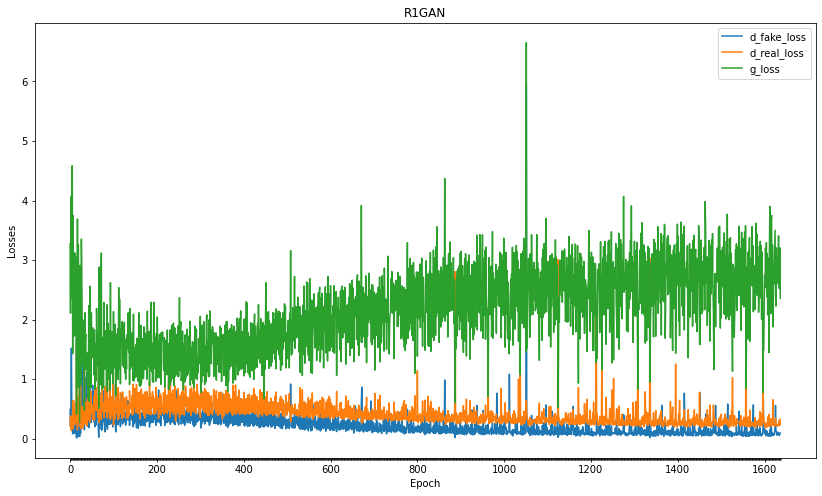

In [ ]:
plot_all_loss(MODEL_NAME, f'{PLOT_DIR}/losses_plot.jpg' )

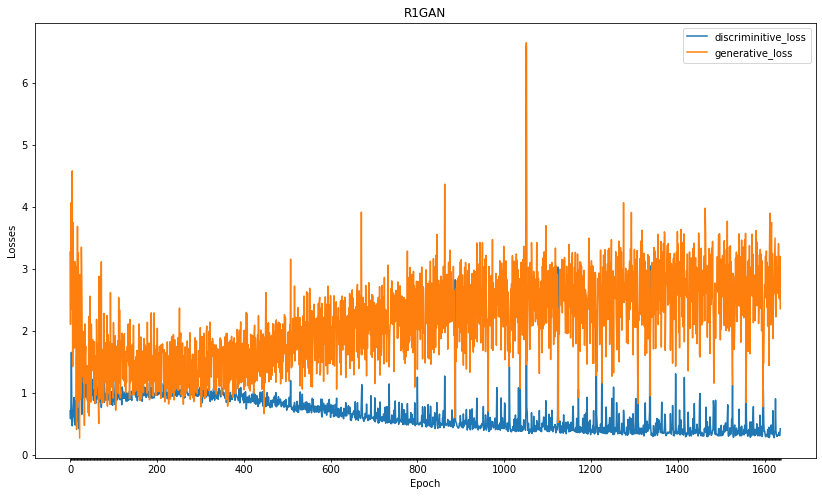

In [ ]:
plot_d_g_loss(MODEL_NAME, f'{PLOT_DIR}/d_g_losses_plot.jpg' )

# Sample

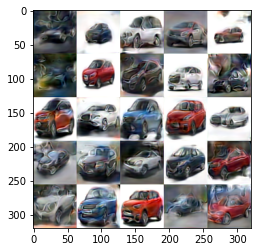

In [ ]:
# generation to image
G.eval()
fake_images = get_sample_image(device, G, n_noise, n_samples=25)
plt.imshow(fake_images)

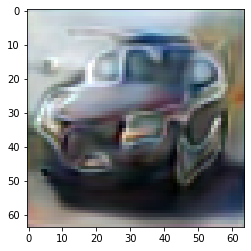

In [ ]:
# Fake Image
idx = [3, 1]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
plt.imshow(fake_images[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

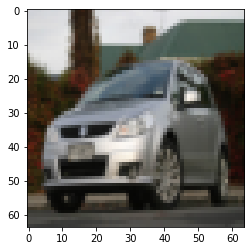

In [ ]:
# Real Image
i = 19
images = next(iter(data_loader))
rimg = tensor2img(images[0][i])
plt.imshow(rimg)

# Interpolation

In [ ]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [ ]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(device)
zs = torch.transpose(zs, 0, 1)
zs.shape

torch.Size([10, 256])

In [ ]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

torch.Size([3, 64, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


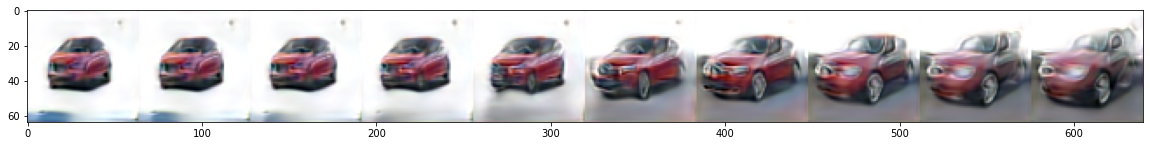

In [ ]:
fig = plt.figure(figsize=(20, 3))
plt.imshow(tensor2img(imgs))